Оператор сотовой связи предоставляет на выбор два тарифных плана: «Смарт» и «Ультра». Сейяас компания хочет выяснить, какой из тарифов для нее выгоднее для того,чтобы перераспределить рекламный бюджет и продвигать активнее более выгодный тариф. 


Задача: сделать предварительный анализ тарифов. В качестве источника информации имеются данные о поведении 500 пользователей: кто они, где живут, каким тарифом пользуются, сколько звонков и сообщений каждый из них отправил за год. 

**Описание данных**


Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана


Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок


Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение


Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя


Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)



**ОГЛАВЛЕНИЕ**
1. [Шаг 1. Откройте файл с данными и изучите общую информацию](#step1)
2. [Шаг 2. Подготовьте данные](#step2)
    1. [Приведите данные к нужным типам](#step2A)
    2. [Найдите и исправьте ошибки в данных](#step2B)
    3. [Посчитайте для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам](#step2C)
    4. [Посчитайте для каждого пользователя количество отправленных сообщений по месяцам](#step2D)
    5. [Посчитайте для каждого пользователя объем израсходованного интернет-трафика по месяцам](#step2E)
    6. [Посчитайте для каждого пользователя помесячную выручку с каждого пользователя](#step2F)
3. [Шаг 3. Проанализируйте данные](#step3)
4. [Шаг 4. Проверьте гипотезы](#step4)
    1. [средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;](#step4A)
    2. [средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;](#step4B)
5. [Шаг 5. Напишите общий вывод](#step5)

In [1]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
from matplotlib import pyplot as plt
import matplotlib

<a id="step1"></a>
### Шаг 1. Откройте файл с данными и изучите общую информацию

таблица всех звонков всех пользователей

In [2]:
calls = pd.read_csv('calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


In [5]:
calls['call_date'].min()

'2018-01-01'

In [6]:
calls['call_date'].max()

'2018-12-31'

представлены данные за 2018 год. пропусков нет, заголовки столбцов корректные. дату нужно привести к формату даты

таблица использования трафика

In [7]:
internet = pd.read_csv('internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [9]:
internet.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


In [10]:
internet['session_date'].min()

'2018-01-01'

In [11]:
internet['session_date'].max()

'2018-12-31'

представлены данные за 2018 год. пропусков внутри таблицы нет, но записей меньше, чем в таблице звонков. заголовки столбцов корректные, есть один столбец неясного смысла ("Unnamed: 0"). дату нужно привести к формату даты

таблица сообщений

In [12]:
messages = pd.read_csv('messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [14]:
messages['message_date'].min()

'2018-01-02'

In [15]:
messages['message_date'].max()

'2018-12-31'

представлены данные за 2018 год. пропусков внутри таблицы нет, записей еще меньше. заголовки столбцов корректные. дату нужно привести к формату даты

таблица описания тарифов

In [16]:
tariffs = pd.read_csv('tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [17]:
tariffs['tariff'] = tariffs['tariff_name']

In [18]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,tariff
0,50,15360,500,550,200,3,3,smart,smart
1,1000,30720,3000,1950,150,1,1,ultra,ultra


таблица информации о пользователях

In [19]:
users = pd.read_csv('users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


выборка 500 человек, названия столбцов корректные. 38 записей о прекращении пользования тарифом. дату регистрации и прекращения пользования нужно привести к формату даты, город, имя и фамилию пользователя нужно привести к строчным буквам

### Вывод

Нам предоставлены данные о том, как пользовались услугами 500 абонентов оператора "Мегалайн" в 2018 году. Данные представлены в 5 таблицах, пропусков внутри таблиц нет, отдельные столбцы нуждаются в корректировке формата

<a id="step2"></a>
### Шаг 2. Подготовьте данные

<a id="step2A"></a>
#### Приведите данные к нужным типам

In [21]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [22]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [23]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [24]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [25]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [26]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [27]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [28]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [29]:
users['city'] = users['city'].str.lower()

In [30]:
users['first_name'] = users['first_name'].str.lower()

In [31]:
users['last_name'] = users['last_name'].str.lower()

In [32]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra
1,1001,41,NaT,москва,иван,ежов,2018-11-01,smart
2,1002,59,NaT,стерлитамак,евгений,абрамович,2018-06-17,smart
3,1003,23,NaT,москва,белла,белякова,2018-08-17,ultra
4,1004,68,NaT,новокузнецк,татьяна,авдеенко,2018-05-14,ultra


поиск дубликатов

In [33]:
calls.duplicated().sum()

0

In [34]:
internet.duplicated().sum()

0

In [35]:
messages.duplicated().sum()

0

In [36]:
users.duplicated().sum()

0

дубликатов не обнаружено

<a id="step2B"></a>
#### Найдите и исправьте ошибки в данных

оператор округляет вверх длительность звонков и использованный трафик. в данных же неокругленные значения. исправим ошибку

In [37]:
def rounded(duration):
    if duration == 0:
        return duration
    else:
        return round(duration+0.5)

In [38]:
#rounded(2.17)

In [39]:
#calls['duration_rounded'] = calls['duration'].apply(rounded)

In [40]:
calls['duration_rounded'] = calls['duration'].apply(np.ceil)

In [41]:
calls['duration_rounded'] = calls['duration_rounded'].astype(int)

In [42]:
calls.head()

,id,call_date,duration,user_id,duration_rounded
0,1000_0,2018-07-25,0.00,1000,0
1,1000_1,2018-08-17,0.00,1000,0
2,1000_2,2018-06-11,2.85,1000,3
3,1000_3,2018-09-21,13.80,1000,14
4,1000_4,2018-12-15,5.18,1000,6


In [43]:
internet['mb_used_rounded'] = internet['mb_used'].apply(rounded) 

In [44]:
internet['mb_used_rounded'] = internet['mb_used_rounded'].astype(int)

In [45]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,mb_used_rounded
0,0,1000_0,112.95,2018-11-25,1000,113
1,1,1000_1,1052.81,2018-09-07,1000,1053
2,2,1000_2,1197.26,2018-06-25,1000,1198
3,3,1000_3,550.27,2018-08-22,1000,551
4,4,1000_4,302.56,2018-09-24,1000,303


в данных хранятся точные даты звонков, смс и пользования трафиком. для расчета ежемесячных показателей достаточно знать, в каком месяце произошло событие

In [46]:
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

In [47]:
calls.head()

,id,call_date,duration,user_id,duration_rounded,month
0,1000_0,2018-07-25,0.00,1000,0,2018-07-01
1,1000_1,2018-08-17,0.00,1000,0,2018-08-01
2,1000_2,2018-06-11,2.85,1000,3,2018-06-01
3,1000_3,2018-09-21,13.80,1000,14,2018-09-01
4,1000_4,2018-12-15,5.18,1000,6,2018-12-01


In [48]:
internet['month'] = internet['session_date'].values.astype('datetime64[M]')

In [49]:
messages['month'] = messages['message_date'].values.astype('datetime64[M]')

<a id="step2C"></a>
#### Посчитайте для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам

In [50]:
monthly_calls = calls.groupby(['user_id', 'month']).agg({'duration_rounded':'sum', 'id':'count'}).reset_index().rename(columns={"id": "calls"})

In [51]:
monthly_calls

,user_id,month,duration_rounded,calls
0,1000,2018-05-01,159,22
1,1000,2018-06-01,172,43
2,1000,2018-07-01,340,47
3,1000,2018-08-01,408,52
4,1000,2018-09-01,466,58
...,...,...,...,...
3169,1498,2018-10-01,247,41
3170,1499,2018-09-01,70,9
3171,1499,2018-10-01,449,68
3172,1499,2018-11-01,612,74


In [52]:
monthly_calls['duration_rounded'].sum()

1450301

In [53]:
monthly_calls['calls'].sum()

202607

<a id="step2D"></a>
#### Посчитайте для каждого пользователя количество отправленных сообщений по месяцам

In [54]:
monthly_messages = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index().rename(columns={"id": "messages"})

In [55]:
monthly_messages

,user_id,month,messages
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
...,...,...,...
2712,1498,2018-10-01,42
2713,1499,2018-09-01,11
2714,1499,2018-10-01,48
2715,1499,2018-11-01,59


In [56]:
monthly_messages['messages'].sum()

123036

<a id="step2E"></a>
#### Посчитайте для каждого пользователя объем израсходованного интернет-трафика по месяцам

In [57]:
monthly_internet = internet.groupby(['user_id', 'month']).agg({'mb_used_rounded':'sum'}).reset_index()

In [58]:
monthly_internet

,user_id,month,mb_used_rounded
0,1000,2018-05-01,2256
1,1000,2018-06-01,23257
2,1000,2018-07-01,14016
3,1000,2018-08-01,14070
4,1000,2018-09-01,14581
...,...,...,...
3198,1498,2018-10-01,20604
3199,1499,2018-09-01,1848
3200,1499,2018-10-01,17809
3201,1499,2018-11-01,17984


In [59]:
monthly_internet['mb_used_rounded'].sum()

55370137

<a id="step2F"></a>
#### Посчитайте для каждого пользователя помесячную выручку с каждого пользователя

In [60]:
df = monthly_calls.merge(monthly_messages, on=['user_id', 'month'], how='outer')

In [61]:
df

,user_id,month,duration_rounded,calls,messages
0,1000,2018-05-01,159.0,22.0,22.0
1,1000,2018-06-01,172.0,43.0,60.0
2,1000,2018-07-01,340.0,47.0,75.0
3,1000,2018-08-01,408.0,52.0,81.0
4,1000,2018-09-01,466.0,58.0,57.0
...,...,...,...,...,...
3208,1489,2018-08-01,NaN,NaN,17.0
3209,1489,2018-09-01,NaN,NaN,32.0
3210,1489,2018-10-01,NaN,NaN,21.0
3211,1489,2018-11-01,NaN,NaN,20.0


In [62]:
df = df.merge(monthly_internet, on=['user_id', 'month'], how='outer')

In [63]:
df

,user_id,month,duration_rounded,calls,messages,mb_used_rounded
0,1000,2018-05-01,159.0,22.0,22.0,2256.0
1,1000,2018-06-01,172.0,43.0,60.0,23257.0
2,1000,2018-07-01,340.0,47.0,75.0,14016.0
3,1000,2018-08-01,408.0,52.0,81.0,14070.0
4,1000,2018-09-01,466.0,58.0,57.0,14581.0
...,...,...,...,...,...,...
3209,1489,2018-09-01,NaN,NaN,32.0,17232.0
3210,1489,2018-10-01,NaN,NaN,21.0,19588.0
3211,1489,2018-11-01,NaN,NaN,20.0,17516.0
3212,1489,2018-12-01,NaN,NaN,35.0,17341.0


In [64]:
df['duration_rounded'].sum()

1450301.0

In [65]:
df['calls'].sum()

202607.0

In [66]:
df['messages'].sum()

123036.0

In [67]:
df['mb_used_rounded'].sum()

55370137.0

все контрольные цифры сошлись

In [68]:
#df = df.merge(users, on='user_id', how='left')

In [69]:
df = df.merge(users[['user_id', 'city', 'tariff']], on='user_id', how='left')

In [70]:
df = df.merge(tariffs, on='tariff', how='left')

In [71]:
df

,user_id,month,duration_rounded,calls,messages,mb_used_rounded,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,2018-05-01,159.0,22.0,22.0,2256.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,2018-06-01,172.0,43.0,60.0,23257.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,2018-07-01,340.0,47.0,75.0,14016.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,2018-08-01,408.0,52.0,81.0,14070.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,2018-09-01,466.0,58.0,57.0,14581.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,2018-09-01,NaN,NaN,32.0,17232.0,санкт-петербург,smart,50,15360,500,550,200,3,3,smart
3210,1489,2018-10-01,NaN,NaN,21.0,19588.0,санкт-петербург,smart,50,15360,500,550,200,3,3,smart
3211,1489,2018-11-01,NaN,NaN,20.0,17516.0,санкт-петербург,smart,50,15360,500,550,200,3,3,smart
3212,1489,2018-12-01,NaN,NaN,35.0,17341.0,санкт-петербург,smart,50,15360,500,550,200,3,3,smart


In [72]:
len(df['user_id'].unique())

498

In [73]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,3214.0,1251.590230,144.659172,1000.0,1125.0,1253.0,1378.75,1499.0
duration_rounded,3174.0,456.931632,238.031270,0.0,290.0,447.0,592.00,1673.0
calls,3174.0,63.833333,32.678036,1.0,41.0,63.0,83.00,244.0
messages,2717.0,45.283769,35.051363,1.0,19.0,38.0,63.00,224.0
mb_used_rounded,3203.0,17286.961286,7523.665433,0.0,12543.0,16985.0,21455.50,49789.0
messages_included,3214.0,341.148102,438.044726,50.0,50.0,50.0,1000.00,1000.0
mb_per_month_included,3214.0,20067.405103,7082.491569,15360.0,15360.0,15360.0,30720.00,30720.0
minutes_included,3214.0,1266.179216,1152.749279,500.0,500.0,500.0,3000.00,3000.0
rub_monthly_fee,3214.0,979.060361,645.539596,550.0,550.0,550.0,1950.00,1950.0
rub_per_gb,3214.0,184.676416,23.054986,150.0,150.0,200.0,200.00,200.0


пропущенные значения в столбцах duration_rounded, calls, messages, mb_used_rounded заменим на 0

In [74]:
df['duration_rounded'] = df['duration_rounded'].fillna(0)

In [75]:
df['calls'] = df['calls'].fillna(0)

In [76]:
df['messages'] = df['messages'].fillna(0)

In [77]:
df['mb_used_rounded'] = df['mb_used_rounded'].fillna(0)

In [78]:
df

,user_id,month,duration_rounded,calls,messages,mb_used_rounded,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,2018-05-01,159.0,22.0,22.0,2256.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,2018-06-01,172.0,43.0,60.0,23257.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,2018-07-01,340.0,47.0,75.0,14016.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,2018-08-01,408.0,52.0,81.0,14070.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,2018-09-01,466.0,58.0,57.0,14581.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,2018-09-01,0.0,0.0,32.0,17232.0,санкт-петербург,smart,50,15360,500,550,200,3,3,smart
3210,1489,2018-10-01,0.0,0.0,21.0,19588.0,санкт-петербург,smart,50,15360,500,550,200,3,3,smart
3211,1489,2018-11-01,0.0,0.0,20.0,17516.0,санкт-петербург,smart,50,15360,500,550,200,3,3,smart
3212,1489,2018-12-01,0.0,0.0,35.0,17341.0,санкт-петербург,smart,50,15360,500,550,200,3,3,smart


In [79]:
df['minutes_overrun'] = df['duration_rounded'] - df['minutes_included']

In [80]:
df['messages_overrun'] = df['messages'] - df['messages_included']

In [81]:
df['mb_overrun'] = df['mb_used_rounded'] - df['mb_per_month_included']

In [82]:
df

,user_id,month,duration_rounded,calls,messages,mb_used_rounded,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,minutes_overrun,messages_overrun,mb_overrun
0,1000,2018-05-01,159.0,22.0,22.0,2256.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,-2841.0,-978.0,-28464.0
1,1000,2018-06-01,172.0,43.0,60.0,23257.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,-2828.0,-940.0,-7463.0
2,1000,2018-07-01,340.0,47.0,75.0,14016.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,-2660.0,-925.0,-16704.0
3,1000,2018-08-01,408.0,52.0,81.0,14070.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,-2592.0,-919.0,-16650.0
4,1000,2018-09-01,466.0,58.0,57.0,14581.0,краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,-2534.0,-943.0,-16139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,2018-09-01,0.0,0.0,32.0,17232.0,санкт-петербург,smart,50,15360,500,550,200,3,3,smart,-500.0,-18.0,1872.0
3210,1489,2018-10-01,0.0,0.0,21.0,19588.0,санкт-петербург,smart,50,15360,500,550,200,3,3,smart,-500.0,-29.0,4228.0
3211,1489,2018-11-01,0.0,0.0,20.0,17516.0,санкт-петербург,smart,50,15360,500,550,200,3,3,smart,-500.0,-30.0,2156.0
3212,1489,2018-12-01,0.0,0.0,35.0,17341.0,санкт-петербург,smart,50,15360,500,550,200,3,3,smart,-500.0,-15.0,1981.0


In [83]:
def revenue_min(row):
    overrun = row['minutes_overrun']
    rub_per_minute = row['rub_per_minute']
    if overrun > 0:
        return overrun*rub_per_minute
    else:
        return 0

In [84]:
row_values = [1, 1]    
row_columns = ['minutes_overrun', 'rub_per_minute']

row = pd.Series(data=row_values, index=row_columns) 

In [85]:
print(revenue_min(row))

1


In [86]:
df['revenue_min'] = df.apply(revenue_min, axis=1)

In [87]:
def revenue_messages(row):
    overrun = row['messages_overrun']
    rub_per_message = row['rub_per_message']
    if overrun > 0:
        return overrun*rub_per_message
    else:
        return 0

In [88]:
df['revenue_messages'] = df.apply(revenue_messages, axis=1)

In [89]:
def revenue_mb(row):
    overrun = row['mb_overrun']
    rub_per_mb = row['rub_per_gb'] / 1024
    if overrun > 0:
        return overrun*rub_per_mb
    else:
        return 0

In [90]:
df['revenue_mb'] = df.apply(revenue_mb, axis=1)

In [91]:
#def revenue(row):
    #revenue_min = row['revenue_min']
    #revenue_messages = row['revenue_messages']
    #revenue_mb = row['revenue_mb']
    #tariff = row['tariff_name']
    #if tariff == 'ultra':
        #return revenue_min + revenue_messages + revenue_mb + 1950
    #else:
        #return revenue_min + revenue_messages + revenue_mb + 550

In [92]:
def revenue(row):
    revenue_min = row['revenue_min']
    revenue_messages = row['revenue_messages']
    revenue_mb = row['revenue_mb']
    tariff = row['tariff_name']
    fee = row['rub_monthly_fee']
    return revenue_min + revenue_messages + revenue_mb + fee

In [93]:
df['revenue'] = df.apply(revenue, axis=1)

In [94]:
df

,user_id,month,duration_rounded,calls,messages,mb_used_rounded,city,tariff,messages_included,mb_per_month_included,...,rub_per_message,rub_per_minute,tariff_name,minutes_overrun,messages_overrun,mb_overrun,revenue_min,revenue_messages,revenue_mb,revenue
0,1000,2018-05-01,159.0,22.0,22.0,2256.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2841.0,-978.0,-28464.0,0.0,0.0,0.000000,1950.000000
1,1000,2018-06-01,172.0,43.0,60.0,23257.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2828.0,-940.0,-7463.0,0.0,0.0,0.000000,1950.000000
2,1000,2018-07-01,340.0,47.0,75.0,14016.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2660.0,-925.0,-16704.0,0.0,0.0,0.000000,1950.000000
3,1000,2018-08-01,408.0,52.0,81.0,14070.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2592.0,-919.0,-16650.0,0.0,0.0,0.000000,1950.000000
4,1000,2018-09-01,466.0,58.0,57.0,14581.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2534.0,-943.0,-16139.0,0.0,0.0,0.000000,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,2018-09-01,0.0,0.0,32.0,17232.0,санкт-петербург,smart,50,15360,...,3,3,smart,-500.0,-18.0,1872.0,0.0,0.0,365.625000,915.625000
3210,1489,2018-10-01,0.0,0.0,21.0,19588.0,санкт-петербург,smart,50,15360,...,3,3,smart,-500.0,-29.0,4228.0,0.0,0.0,825.781250,1375.781250
3211,1489,2018-11-01,0.0,0.0,20.0,17516.0,санкт-петербург,smart,50,15360,...,3,3,smart,-500.0,-30.0,2156.0,0.0,0.0,421.093750,971.093750
3212,1489,2018-12-01,0.0,0.0,35.0,17341.0,санкт-петербург,smart,50,15360,...,3,3,smart,-500.0,-15.0,1981.0,0.0,0.0,386.914062,936.914062


In [95]:
df['revenue'].sum()

4778837.23046875

### Вывод

- Мы использовали метод pd.to_datetime и привели к формату времени данные о дате совершения звонков, отправки сообщений, использования интренета, а также о дате регистрации абонента и (при наличии) о дате прекращения обслуживания. 
- Мы использовали метод str.lower() и привели к нижнему регистру данные о имени, фамилии и регионе проживания абонента
- Мы убедились в отсутсвии дубликатов в таблицах 
- Мы исправили ошибки в данных: округлили вверх продолжительность всех звонков и количество использованного интернет-трафика (покольку при расчетах с абонентами "Мегалайн" округляет вверз значения минут и мегабайтов), а также привели даты звонков, сообщений и пользования тарфиком к первому дню соответсвующего месяца для расчета показателей по месяцам
- Мы использовали группировку по пользователю и месяцу, чтобы рассчитать количество минут разговора, сообщений и мегабайтов трафика, которые израсходовал каждый пользователь в каждый месяц
- Мы рассчитали выручку, которую получил "мегалайн" от каждого пользователя. Для этого необходимо было к ежемесячной абонентской плате (зависит от тарифа) прибавить перерасход по каждой из услуг, умноженный на цену минуты разговора, сообщения или мегабайта трафика сверх установленного тарифом лимита. То есть если абонент в данный не пользуется услугами сверх установленных тарифом лимитов, то выручка "мегалайна" составит лишь величину абонентской платы 
- Для создания сводной таблицы мы использовали метод .merge с необходимыми параметрами
- Контрольные цифры (суммарное для всех пользователей количество минут разговора, сообщений и трафика до и после объединения) сошлись, что свидетельствует о корректном объединении таблиц
- Общая выручка по 500 пользователям в 2018 году составила 4779626 рублей

<a id="step3"></a>
### Шаг 3. Проанализируйте данные

разделим датафрейм по признаку тарифа

**тариф "ультра"**

In [96]:
df_ultra = df.query('tariff_name == "ultra"')

In [97]:
df_ultra

,user_id,month,duration_rounded,calls,messages,mb_used_rounded,city,tariff,messages_included,mb_per_month_included,...,rub_per_message,rub_per_minute,tariff_name,minutes_overrun,messages_overrun,mb_overrun,revenue_min,revenue_messages,revenue_mb,revenue
0,1000,2018-05-01,159.0,22.0,22.0,2256.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2841.0,-978.0,-28464.0,0.0,0.0,0.0,1950.0
1,1000,2018-06-01,172.0,43.0,60.0,23257.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2828.0,-940.0,-7463.0,0.0,0.0,0.0,1950.0
2,1000,2018-07-01,340.0,47.0,75.0,14016.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2660.0,-925.0,-16704.0,0.0,0.0,0.0,1950.0
3,1000,2018-08-01,408.0,52.0,81.0,14070.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2592.0,-919.0,-16650.0,0.0,0.0,0.0,1950.0
4,1000,2018-09-01,466.0,58.0,57.0,14581.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2534.0,-943.0,-16139.0,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,1473,2018-09-01,0.0,0.0,19.0,17307.0,красноярск,ultra,1000,30720,...,1,1,ultra,-3000.0,-981.0,-13413.0,0.0,0.0,0.0,1950.0
3205,1473,2018-10-01,0.0,0.0,20.0,13704.0,красноярск,ultra,1000,30720,...,1,1,ultra,-3000.0,-980.0,-17016.0,0.0,0.0,0.0,1950.0
3206,1473,2018-11-01,0.0,0.0,14.0,21692.0,красноярск,ultra,1000,30720,...,1,1,ultra,-3000.0,-986.0,-9028.0,0.0,0.0,0.0,1950.0
3207,1473,2018-12-01,0.0,0.0,20.0,18432.0,красноярск,ultra,1000,30720,...,1,1,ultra,-3000.0,-980.0,-12288.0,0.0,0.0,0.0,1950.0


In [98]:
len(df_ultra['user_id'].unique())

148

In [99]:
print(df_ultra['revenue'].sum())

2029629.78515625


In [100]:
ultra_month_rev_per_user = df_ultra['revenue'].sum() / len(df_ultra['user_id'].unique()) / 12

In [101]:
ultra_month_rev_per_user

1142.8095637141048

In [102]:
df_ultra.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,985.0,1263.094416,140.694908,1000.0,1143.0,1277.0,1381.0,1495.000000
duration_rounded,985.0,526.623350,317.606098,0.0,284.0,518.0,752.0,1673.000000
calls,985.0,73.392893,43.916853,0.0,41.0,74.0,104.0,244.000000
messages,985.0,49.363452,47.804457,0.0,6.0,38.0,79.0,224.000000
mb_used_rounded,985.0,19487.094416,10096.416865,0.0,11785.0,19324.0,26864.0,49789.000000
messages_included,985.0,1000.000000,0.000000,1000.0,1000.0,1000.0,1000.0,1000.000000
mb_per_month_included,985.0,30720.000000,0.000000,30720.0,30720.0,30720.0,30720.0,30720.000000
minutes_included,985.0,3000.000000,0.000000,3000.0,3000.0,3000.0,3000.0,3000.000000
rub_monthly_fee,985.0,1950.000000,0.000000,1950.0,1950.0,1950.0,1950.0,1950.000000
rub_per_gb,985.0,150.000000,0.000000,150.0,150.0,150.0,150.0,150.000000


средние показатели пользования услугами на тарифе "ультра":
- звонки - 527 минут (стандартное отклонение = 318, дисперсия = 318*318 = 101124 )
- сообщения - 50 (стандартное отклонение = 48, дисперсия = 48*48 = 2304)
- интернет-трафик - 19,5 Гб ((стандартное отклонение = 10 Гб, дисперсия = 10*10 = 100))
- выручка - 2061 (стандартное отклонение = 356, дисперсия = 356*356 = 126736 )


Как мы видим, в среднем пользователи тарифа "ультра" не используют весь предоставленный им лимит услуг. Особенно по смс (в среднем используют 50 смс в месяц или 5% от лимита). Минуты разговора также используются значительно меньше лимита (в среднем 526 минут в месяц или 17,5% лимита). Интернет-трафик используется активнее: в среднем около 20 Гб или 2/3 лимита</font>

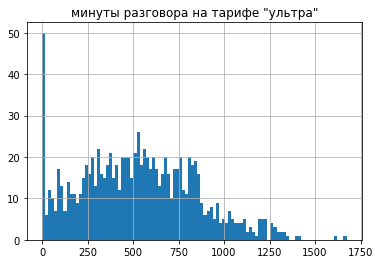

In [103]:
df_ultra['duration_rounded'].hist(bins=100)
plt.title('минуты разговора на тарифе "ультра"')
plt.show()

распределение похоже на распределение Пирсона, но есть достаточно большое количество пользователей, которые вообще не используют минуты разговора

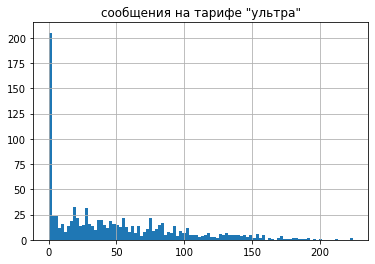

In [104]:
df_ultra['messages'].hist(bins=100)
plt.title('сообщения на тарифе "ультра"')
plt.show()

распределение похоже на распределение Пирсона, но есть достаточно большое количество пользователей, которые вообще не используют сообщения

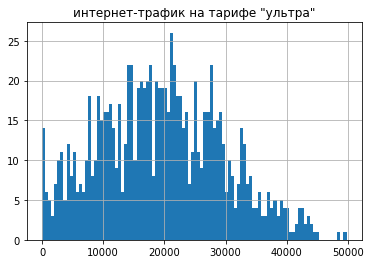

In [105]:
df_ultra['mb_used_rounded'].hist(bins=100)
plt.title('интернет-трафик на тарифе "ультра"')
plt.show()

распределение величины использования интернет-трафика больше других похоже на нормальное

**тариф "смарт"**

In [106]:
df_smart = df.query('tariff_name == "smart"')

In [107]:
df_smart

,user_id,month,duration_rounded,calls,messages,mb_used_rounded,city,tariff,messages_included,mb_per_month_included,...,rub_per_message,rub_per_minute,tariff_name,minutes_overrun,messages_overrun,mb_overrun,revenue_min,revenue_messages,revenue_mb,revenue
8,1001,2018-11-01,430.0,59.0,0.0,18452.0,москва,smart,50,15360,...,3,3,smart,-70.0,-50.0,3092.0,0.0,0.0,603.906250,1153.906250
9,1001,2018-12-01,414.0,63.0,0.0,14053.0,москва,smart,50,15360,...,3,3,smart,-86.0,-50.0,-1307.0,0.0,0.0,0.000000,550.000000
10,1002,2018-06-01,117.0,15.0,4.0,10871.0,стерлитамак,smart,50,15360,...,3,3,smart,-383.0,-46.0,-4489.0,0.0,0.0,0.000000,550.000000
11,1002,2018-07-01,214.0,26.0,11.0,17601.0,стерлитамак,smart,50,15360,...,3,3,smart,-286.0,-39.0,2241.0,0.0,0.0,437.695312,987.695312
12,1002,2018-08-01,289.0,42.0,13.0,20347.0,стерлитамак,smart,50,15360,...,3,3,smart,-211.0,-37.0,4987.0,0.0,0.0,974.023438,1524.023438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,1489,2018-08-01,0.0,0.0,17.0,11066.0,санкт-петербург,smart,50,15360,...,3,3,smart,-500.0,-33.0,-4294.0,0.0,0.0,0.000000,550.000000
3209,1489,2018-09-01,0.0,0.0,32.0,17232.0,санкт-петербург,smart,50,15360,...,3,3,smart,-500.0,-18.0,1872.0,0.0,0.0,365.625000,915.625000
3210,1489,2018-10-01,0.0,0.0,21.0,19588.0,санкт-петербург,smart,50,15360,...,3,3,smart,-500.0,-29.0,4228.0,0.0,0.0,825.781250,1375.781250
3211,1489,2018-11-01,0.0,0.0,20.0,17516.0,санкт-петербург,smart,50,15360,...,3,3,smart,-500.0,-30.0,2156.0,0.0,0.0,421.093750,971.093750


In [108]:
print(len(df_smart['user_id'].unique()))

350


In [109]:
print(df_smart['revenue'].sum())

2749207.4453125


In [110]:
smart_month_rev_per_user = df_smart['revenue'].sum() / len(df_smart['user_id'].unique()) / 12

In [111]:
smart_month_rev_per_user

654.5732012648809

In [112]:
df_smart.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,2229.0,1246.506505,146.119496,1001.0,1121.0,1239.000000,1376.000000,1499.000000
duration_rounded,2229.0,417.934948,190.313730,0.0,282.0,422.000000,545.000000,1435.000000
calls,2229.0,58.463437,25.939858,0.0,40.0,60.000000,76.000000,198.000000
messages,2229.0,33.384029,28.227876,0.0,10.0,28.000000,51.000000,143.000000
mb_used_rounded,2229.0,16229.407358,5877.665412,0.0,12658.0,16531.000000,20068.000000,38610.000000
messages_included,2229.0,50.000000,0.000000,50.0,50.0,50.000000,50.000000,50.000000
mb_per_month_included,2229.0,15360.000000,0.000000,15360.0,15360.0,15360.000000,15360.000000,15360.000000
minutes_included,2229.0,500.000000,0.000000,500.0,500.0,500.000000,500.000000,500.000000
rub_monthly_fee,2229.0,550.000000,0.000000,550.0,550.0,550.000000,550.000000,550.000000
rub_per_gb,2229.0,200.000000,0.000000,200.0,200.0,200.000000,200.000000,200.000000


средние показатели пользования услугами на тарифе "смарт":
- звонки - 418 минут (стандартное отклонение = 190, дисперсия = 190*190 = 36100 )
- сообщения - 33 (стандартное отклонение = 28, дисперсия = 28*28 = 784)
- интернет-трафик - 16,2 Гб (стандартное отклонение = 5,8 Гб, дисперсия = 5,8*5,8 = 33,64)
- выручка 1234 (стандартное отклонение = 788, дисперсия = 788*788 = 620944)


Как мы видим, в среднем пользователи тарифа "смарт" также не используют весь предоставленный им лимит услуг по минутам разговора и смс. Лимит сообщений используется в среднем на 66% (33 сообщения при лимите в 50). Минуты разговора используются на 83% (в среднем 417 минут в месяц при лимите в 500 минут). А вот по использованию трафика пользователи тарифа "смарт" в среднем превосходят лимит примерно на 5,6% (16229 мб интернета при лимите в 15360 мб)</font>

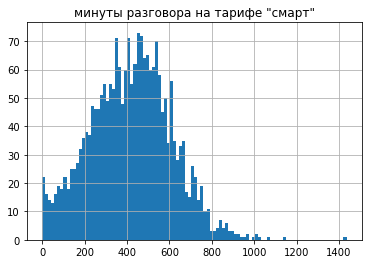

In [113]:
df_smart['duration_rounded'].hist(bins=100)
plt.title('минуты разговора на тарифе "смарт"')
plt.show()

распределение похоже на нормальное  

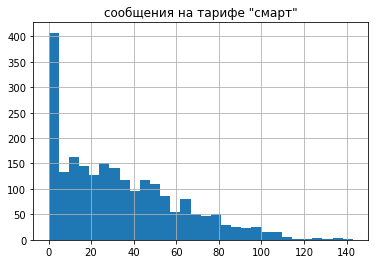

In [114]:
df_smart['messages'].hist(bins=30)
plt.title('сообщения на тарифе "смарт"')
plt.show()

распределение похоже на распределение Пирсона, но есть достаточно большое количество пользователей, которые вообще не используют сообщения

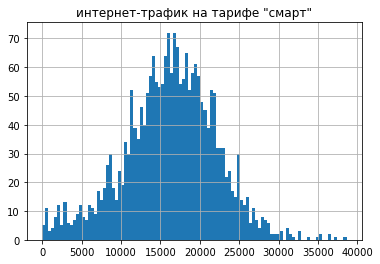

In [115]:
df_smart['mb_used_rounded'].hist(bins=100)
plt.title('интернет-трафик на тарифе "смарт"')
plt.show()

распределение величины использования интернет-трафика очень похоже на нормальное

### Вывод

Мы определили основные статистические характеристики, описывающие поведение абонентов тарифов "ультра" и "смарт"


средние показатели пользования услугами на тарифе "ультра":
- звонки - 527 минут (стандартное отклонение = 318, дисперсия = 318*318 = 101124 )
- сообщения - 50 (стандартное отклонение = 48, дисперсия = 48*48 = 2304)
- интернет-трафик - 19,5 Гб (стандартное отклонение = 10 Гб, дисперсия = 10*10 = 100) 
- выручка - 2061 (стандартное отклонение = 356, дисперсия = 356*356 = 126736 )


в среднем пользователи тарифа "ультра" не используют весь предоставленный им лимит услуг. Особенно по смс (в среднем используют 50 смс в месяц или 5% от лимита). Минуты разговора также используются значительно меньше лимита (в среднем 526 минут в месяц или 17,5% лимита). Интернет-трафик используется активнее: в среднем около 20 Гб или 2/3 лимита</font>


гистограммы распределения на тарифе "ультра" показали:
- распределение минут разговора и количества отправленных сообщений не похоже внешне на нормальное распределение. есть сходство с распределением пирсона, однако и для минут, и для сообщений есть большое количество нулевых значений. 
- распределение объема использованного трафика напоминает внешне нормальное распределение


средние показатели пользования услугами на тарифе "смарт":
- звонки - 418 минут (стандартное отклонение = 190, дисперсия = 190*190 = 36100 )
- сообщения - 33 (стандартное отклонение = 28, дисперсия = 28*28 = 784)
- интернет-трафик - 16,2 Гб (стандартное отклонение = 5,8 Гб, дисперсия = 5,8*5,8 = 33,64)
- выручка 1234 (стандартное отклонение = 788, дисперсия = 788*788 = 620944)


в среднем пользователи тарифа "смарт" также не используют весь предоставленный им лимит услуг по минутам разговора и смс. Лимит сообщений используется в среднем на 66% (33 сообщения при лимите в 50). Минуты разговора используются на 83% (в среднем 417 минут в месяц при лимите в 500 минут). А вот по использованию трафика пользователи тарифа "смарт" в среднем превосходят лимит примерно на 5,6% (16229 мб интернета при лимите в 15360 мб)</font>


гистограммы распределения на тарифе "смарт" показали:
- распределение минут разговора и объема использованного трафика напоминает внешне нормальное распределение
- распределение количества отправленных сообщений не похоже внешне на нормальное распределение. есть сходство с распределением пирсона, однако есть большое количество нулевых значений. 

<a id="step4"></a>
### Шаг 4. Проверьте гипотезы

<a id="step4A"></a>
#### средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Формулируем гипотезу Н0 (так, чтобы использовать знак равенства): *средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковы*


Следовательно, альтернативная гипотеза Н1 формулируется так: *средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются*


Поскольку нам неважно в данном случае, как конкретно они различаются (что больше, а что меньше), то гипотеза является *двухсторонней*


У каждого пользователя может быть только один тариф, поэтому выборки *не связанные*


Уровень значимости (вероятность ошибиться, отвергнув гипотезу Н0) установим на уровне 0,05

In [116]:
results = st.ttest_ind(df_ultra['revenue'], df_smart['revenue'], equal_var=True)
results.pvalue

1.227485000376771e-190

In [117]:
results = st.ttest_ind(df_ultra['revenue'], df_smart['revenue'], equal_var=False)
results.pvalue

9.586738556735646e-296

Независимо от предположения о равенстве/неравенстве дисперсий, p-value оказалось меньше 0,05, что дает основания отвергнуть гипотезу о равенстве средней выручки пользваотелей тарифов «Ультра» и «Смарт»   

<a id="step4B"></a>
#### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

для ответа на этот вопрос необходима предварительная подготовка данных - разделение общего датафрейма по признаку 'city'

In [118]:
df_moscow = df.query('city == "москва"')

In [119]:
df_moscow

,user_id,month,duration_rounded,calls,messages,mb_used_rounded,city,tariff,messages_included,mb_per_month_included,...,rub_per_message,rub_per_minute,tariff_name,minutes_overrun,messages_overrun,mb_overrun,revenue_min,revenue_messages,revenue_mb,revenue
8,1001,2018-11-01,430.0,59.0,0.0,18452.0,москва,smart,50,15360,...,3,3,smart,-70.0,-50.0,3092.0,0.0,0.0,603.906250,1153.906250
9,1001,2018-12-01,414.0,63.0,0.0,14053.0,москва,smart,50,15360,...,3,3,smart,-86.0,-50.0,-1307.0,0.0,0.0,0.000000,550.000000
17,1003,2018-08-01,380.0,55.0,37.0,8571.0,москва,ultra,1000,30720,...,1,1,ultra,-2620.0,-963.0,-22149.0,0.0,0.0,0.000000,1950.000000
18,1003,2018-09-01,961.0,134.0,91.0,12479.0,москва,ultra,1000,30720,...,1,1,ultra,-2039.0,-909.0,-18241.0,0.0,0.0,0.000000,1950.000000
19,1003,2018-10-01,855.0,108.0,83.0,14779.0,москва,ultra,1000,30720,...,1,1,ultra,-2145.0,-917.0,-15941.0,0.0,0.0,0.000000,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119,1490,2018-09-01,322.0,44.0,48.0,14838.0,москва,smart,50,15360,...,3,3,smart,-178.0,-2.0,-522.0,0.0,0.0,0.000000,550.000000
3120,1490,2018-10-01,312.0,42.0,45.0,20690.0,москва,smart,50,15360,...,3,3,smart,-188.0,-5.0,5330.0,0.0,0.0,1041.015625,1591.015625
3121,1490,2018-11-01,282.0,38.0,47.0,18734.0,москва,smart,50,15360,...,3,3,smart,-218.0,-3.0,3374.0,0.0,0.0,658.984375,1208.984375
3122,1490,2018-12-01,290.0,42.0,46.0,15806.0,москва,smart,50,15360,...,3,3,smart,-210.0,-4.0,446.0,0.0,0.0,87.109375,637.109375


In [120]:
df_moscow.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,611.0,1268.872340,137.530432,1001.0,1171.000000,1291.000000,1385.000000,1490.000000
duration_rounded,611.0,469.150573,241.535044,0.0,304.000000,453.000000,620.500000,1321.000000
calls,611.0,65.436989,33.186021,0.0,42.000000,64.000000,85.500000,188.000000
messages,611.0,37.877250,37.160304,0.0,6.500000,29.000000,57.000000,191.000000
mb_used_rounded,611.0,17984.289689,7852.100318,366.0,12628.000000,17557.000000,22143.500000,44341.000000
messages_included,611.0,399.836334,458.588325,50.0,50.000000,50.000000,1000.000000,1000.000000
mb_per_month_included,611.0,21016.301146,7414.649129,15360.0,15360.000000,15360.000000,30720.000000,30720.000000
minutes_included,611.0,1420.621931,1206.811382,500.0,500.000000,500.000000,3000.000000,3000.000000
rub_monthly_fee,611.0,1065.548282,675.814374,550.0,550.000000,550.000000,1950.000000,1950.000000
rub_per_gb,611.0,181.587561,24.136228,150.0,150.000000,200.000000,200.000000,200.000000


In [121]:
df_others = df.query('city != "москва"')

In [122]:
df_others

,user_id,month,duration_rounded,calls,messages,mb_used_rounded,city,tariff,messages_included,mb_per_month_included,...,rub_per_message,rub_per_minute,tariff_name,minutes_overrun,messages_overrun,mb_overrun,revenue_min,revenue_messages,revenue_mb,revenue
0,1000,2018-05-01,159.0,22.0,22.0,2256.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2841.0,-978.0,-28464.0,0.0,0.0,0.000000,1950.000000
1,1000,2018-06-01,172.0,43.0,60.0,23257.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2828.0,-940.0,-7463.0,0.0,0.0,0.000000,1950.000000
2,1000,2018-07-01,340.0,47.0,75.0,14016.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2660.0,-925.0,-16704.0,0.0,0.0,0.000000,1950.000000
3,1000,2018-08-01,408.0,52.0,81.0,14070.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2592.0,-919.0,-16650.0,0.0,0.0,0.000000,1950.000000
4,1000,2018-09-01,466.0,58.0,57.0,14581.0,краснодар,ultra,1000,30720,...,1,1,ultra,-2534.0,-943.0,-16139.0,0.0,0.0,0.000000,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,1489,2018-08-01,0.0,0.0,17.0,11066.0,санкт-петербург,smart,50,15360,...,3,3,smart,-500.0,-33.0,-4294.0,0.0,0.0,0.000000,550.000000
3209,1489,2018-09-01,0.0,0.0,32.0,17232.0,санкт-петербург,smart,50,15360,...,3,3,smart,-500.0,-18.0,1872.0,0.0,0.0,365.625000,915.625000
3210,1489,2018-10-01,0.0,0.0,21.0,19588.0,санкт-петербург,smart,50,15360,...,3,3,smart,-500.0,-29.0,4228.0,0.0,0.0,825.781250,1375.781250
3211,1489,2018-11-01,0.0,0.0,20.0,17516.0,санкт-петербург,smart,50,15360,...,3,3,smart,-500.0,-30.0,2156.0,0.0,0.0,421.093750,971.093750


In [123]:
df_others.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,2603.0,1247.533615,146.011387,1000.0,1120.000000,1241.000000,1377.000000,1499.000000
duration_rounded,2603.0,447.041875,241.852152,0.0,280.500000,440.000000,584.000000,1673.000000
calls,2603.0,62.475989,33.229464,0.0,40.000000,62.000000,82.000000,244.000000
messages,2603.0,38.376104,35.913289,0.0,9.500000,30.000000,57.000000,224.000000
mb_used_rounded,2603.0,17050.225125,7503.146645,0.0,12468.500000,16874.000000,21258.500000,49789.000000
messages_included,2603.0,327.372263,432.018494,50.0,50.000000,50.000000,1000.000000,1000.000000
mb_per_month_included,2603.0,19844.671533,6985.056917,15360.0,15360.000000,15360.000000,30720.000000,30720.000000
minutes_included,2603.0,1229.927007,1136.890774,500.0,500.000000,500.000000,3000.000000,3000.000000
rub_monthly_fee,2603.0,958.759124,636.658834,550.0,550.000000,550.000000,1950.000000,1950.000000
rub_per_gb,2603.0,185.401460,22.737815,150.0,150.000000,200.000000,200.000000,200.000000


Формулируем гипотезу Н0 (так, чтобы использовать знак равенства): *средняя выручка пользователей из Москвы и выручка пользователей из других регионов одинаковы*


Следовательно, альтернативная гипотеза Н1 формулируется так: *средняя выручка пользователей из Москвы и выручка пользователей из других регионов различаются*


Поскольку нам неважно в данном случае, как конкретно они различаются (что больше, а что меньше), то гипотеза является *двухсторонней*


Каждый пользователь может попасть только в группу "москва" или "другие", поэтому выборки *не связанные*


Уровень значимости (вероятность ошибиться, отвергнув гипотезу Н0) установим на уровне 0,05

In [124]:
results = st.ttest_ind(df_moscow['revenue'], df_others['revenue'], equal_var=True)
results.pvalue

0.47443841636263173

In [125]:
results = st.ttest_ind(df_moscow['revenue'], df_others['revenue'], equal_var=False)
results.pvalue

0.4549826779764625

Независимо от предположения о равенстве/неравенстве дисперсий, p-value оказалось больше 0,05, что не дает основания отвергнуть гипотезу о равенстве средней выручки пользваотелей из Москвы и других регионов  

<a id="step5"></a>
### Вывод

на основании t-теста мы можем отвергнуть гипотезу о равенстве средней выручки пользователей тарифов "ультра" и "смарт". Предоставленные нам данные не подтверждают, что средняя выручка оператора от одного абонента не зависит от того, какой у абонента тариф


на основании t-теста мы не можем отвергнуть гипотезу о равенстве средней выручки пользователей из москвы и других регионов. Предоставленные нам данные не подтверждают, что средняя выручка оператора от одного абонента зависит от того, живет ли абонент в столице или в другом регионе страны</font>

### Общий вывод

На основе проведенного анализа мы можем рекомендовать "мегалайну" активнее продвигать тариф "ультра" как в москве, так и в регионах. В пользу этой рекомендации говорят следующие выводы, сделанные на основе статистического анализа предоставленных данных
1. данные не подтверждают гипотезу о том, что средняя выручка от двух тарифов одинаковая. Значит, имеет смысл сосредоточиться на одном из них. За выбор в пользу тарифа "ультра" говорит средняя выручка от одного пользователя на этом тарифе (2061 против 1234 для абонентов тарифа "смарт") и меньшее стандартное отклонение (меньший разброс) величины выручки (356 против 788 для абонентов тарифа "смарт")
2. данные не опровергают гипотезу о том, что средняя выручка для абонентов столичного региона такая же, как для абонентов из других регионов. Значит, имеет смысл вкладывать средства в продвижение не только в Москве, но и в других регионах.